# Distance Metrics for Matching

**Chapter 10, Section 2**

This notebook covers how to measure "similarity" between units when exact matching isn't possible.

## Table of Contents
1. [Intuition](#intuition) - Why distance matters
2. [Formal Treatment](#formal) - Distance metric definitions
3. [Numeric Demonstration](#numeric) - Comparing metrics on medicine data
4. [Implementation](#implementation) - Feature scaling and matching
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The Problem with Continuous Covariates

Exact matching works when covariates are discrete with limited values. But with continuous covariates:

- Age = 35.04913... has no exact match
- Income = $52,347.23 is unique
- Probability = 0.73421... appears once

We need to find "close enough" matches instead of exact ones.

### Distance as Similarity

**Core insight**: Use a distance function to measure how similar two units are.

$$d(x_i, x_j) = \text{"how different are units } i \text{ and } j \text{ on covariates?"}$$

Small distance = similar units = good match.

### The Feature Scale Problem

Consider matching on age (20-60 years) and income ($20,000-$200,000):

| Unit | Age | Income |
|------|-----|--------|
| A | 30 | $50,000 |
| B | 31 | $50,000 |
| C | 30 | $100,000 |

Naive Euclidean distance:
- $d(A, B) = \sqrt{(30-31)^2 + (50000-50000)^2} = 1$
- $d(A, C) = \sqrt{(30-30)^2 + (50000-100000)^2} = 50000$

Income dominates! A 1-year age difference is treated as negligible compared to income differences.

---

In [2]:
# Load medicine data
med = load_facure_data("medicine_impact_recovery.csv")

print(f"Data: {len(med)} patients")
print(f"Treatment (medication): {med['medication'].mean():.1%} received medication")
print(f"\nColumns: {list(med.columns)}")
print(f"\nFeature ranges:")
for col in ['age', 'severity']:
    print(f"  {col}: [{med[col].min():.2f}, {med[col].max():.2f}]")
med.head()

Data: 20000 patients
Treatment (medication): 34.6% received medication

Columns: ['sex', 'age', 'severity', 'medication', 'recovery']

Feature ranges:
  age: [5.29, 88.43]
  severity: [0.00, 1.00]


,sex,age,severity,medication,recovery
0,0,35.0491,0.8877,1,31
1,1,41.5803,0.8998,1,49
2,1,28.1275,0.4863,0,38
3,1,36.3750,0.3231,0,35
4,0,25.0917,0.2090,0,15


In [3]:
# Show the scale problem
features = ['age', 'severity']
print("SCALE PROBLEM:")
print("=" * 50)
print(f"\nAge range: {med['age'].max() - med['age'].min():.1f} years")
print(f"Severity range: {med['severity'].max() - med['severity'].min():.3f} units")
print(f"\nRatio: Age range / Severity range = {(med['age'].max() - med['age'].min()) / (med['severity'].max() - med['severity'].min()):.0f}x")
print(f"\nAge differences will dominate naive Euclidean distance!")

SCALE PROBLEM:

Age range: 83.1 years
Severity range: 0.998 units

Ratio: Age range / Severity range = 83x

Age differences will dominate naive Euclidean distance!


---

## Formal Treatment

### Distance Metrics

**Definition 1** (Euclidean Distance):

$$d_{Euc}(x_i, x_j) = \sqrt{\sum_{k=1}^{p} (x_{ik} - x_{jk})^2}$$

Standard "as the crow flies" distance. Sensitive to feature scales.

**Definition 2** (Standardized Euclidean Distance):

First standardize features: $\tilde{x}_{ik} = \frac{x_{ik} - \bar{x}_k}{s_k}$

Then compute Euclidean distance on standardized values:

$$d_{SEuc}(x_i, x_j) = \sqrt{\sum_{k=1}^{p} \left(\frac{x_{ik} - x_{jk}}{s_k}\right)^2}$$

**Definition 3** (Mahalanobis Distance):

$$d_{Mah}(x_i, x_j) = \sqrt{(x_i - x_j)' \Sigma^{-1} (x_i - x_j)}$$

where $\Sigma$ is the covariance matrix of $X$.

Accounts for both scale and correlation between features.

### Why Mahalanobis?

| Metric | Handles Scale? | Handles Correlation? |
|--------|---------------|---------------------|
| Euclidean | No | No |
| Standardized Euclidean | Yes | No |
| Mahalanobis | Yes | Yes |

If features are correlated, Mahalanobis "stretches" the space to account for this.

**Key insight**: Standardized Euclidean is a special case of Mahalanobis with diagonal covariance.

---

In [4]:
# Implement distance metrics
def euclidean_distance(x1, x2):
    """Standard Euclidean distance."""
    return np.sqrt(np.sum((x1 - x2)**2))

def standardized_euclidean(x1, x2, means, stds):
    """Euclidean distance on standardized features."""
    z1 = (x1 - means) / stds
    z2 = (x2 - means) / stds
    return np.sqrt(np.sum((z1 - z2)**2))

def mahalanobis_distance(x1, x2, cov_inv):
    """Mahalanobis distance using inverse covariance."""
    diff = x1 - x2
    return np.sqrt(diff @ cov_inv @ diff)

# Prepare data
features = ['age', 'severity']
X = med[features].values
means = X.mean(axis=0)
stds = X.std(axis=0)
cov_matrix = np.cov(X.T)
cov_inv = np.linalg.inv(cov_matrix)

print("Feature statistics:")
print(f"Means: age={means[0]:.2f}, severity={means[1]:.3f}")
print(f"Stds:  age={stds[0]:.2f}, severity={stds[1]:.3f}")
print(f"\nCovariance matrix:")
print(cov_matrix)

Feature statistics:
Means: age=31.91, severity=0.470
Stds:  age=11.17, severity=0.286

Covariance matrix:
[[1.24820095e+02 1.82029586e+00]
 [1.82029586e+00 8.19329708e-02]]


In [5]:
# Compare distances for specific pairs
# Pick a reference patient and compare to two candidates
np.random.seed(42)
ref_idx = np.random.choice(len(med))
ref = X[ref_idx]

# Find patients with different characteristics
# Candidate 1: Similar age, different severity
similar_age_mask = np.abs(X[:, 0] - ref[0]) < 1  # Within 1 year
different_severity_mask = np.abs(X[:, 1] - ref[1]) > 0.3  # Different severity
cand1_mask = similar_age_mask & different_severity_mask
if cand1_mask.sum() > 0:
    cand1_idx = np.where(cand1_mask)[0][0]
else:
    cand1_idx = np.random.choice(len(med))
cand1 = X[cand1_idx]

# Candidate 2: Different age, similar severity
different_age_mask = np.abs(X[:, 0] - ref[0]) > 10  # More than 10 years
similar_severity_mask = np.abs(X[:, 1] - ref[1]) < 0.1  # Similar severity
cand2_mask = different_age_mask & similar_severity_mask
if cand2_mask.sum() > 0:
    cand2_idx = np.where(cand2_mask)[0][0]
else:
    cand2_idx = np.random.choice(len(med))
cand2 = X[cand2_idx]

print("COMPARING DISTANCE METRICS:")
print("=" * 60)
print(f"\nReference patient: age={ref[0]:.1f}, severity={ref[1]:.3f}")
print(f"Candidate 1: age={cand1[0]:.1f}, severity={cand1[1]:.3f} (similar age)")
print(f"Candidate 2: age={cand2[0]:.1f}, severity={cand2[1]:.3f} (similar severity)")

print(f"\nDistances to Reference:")
print(f"{'Metric':<25} {'Candidate 1':<15} {'Candidate 2':<15} {'Better Match'}")
print("-" * 70)

d_euc1 = euclidean_distance(ref, cand1)
d_euc2 = euclidean_distance(ref, cand2)
print(f"{'Euclidean':<25} {d_euc1:<15.3f} {d_euc2:<15.3f} {'Cand 1' if d_euc1 < d_euc2 else 'Cand 2'}")

d_seuc1 = standardized_euclidean(ref, cand1, means, stds)
d_seuc2 = standardized_euclidean(ref, cand2, means, stds)
print(f"{'Standardized Euclidean':<25} {d_seuc1:<15.3f} {d_seuc2:<15.3f} {'Cand 1' if d_seuc1 < d_seuc2 else 'Cand 2'}")

d_mah1 = mahalanobis_distance(ref, cand1, cov_inv)
d_mah2 = mahalanobis_distance(ref, cand2, cov_inv)
print(f"{'Mahalanobis':<25} {d_mah1:<15.3f} {d_mah2:<15.3f} {'Cand 1' if d_mah1 < d_mah2 else 'Cand 2'}")

COMPARING DISTANCE METRICS:

Reference patient: age=42.5, severity=0.848
Candidate 1: age=41.9, severity=0.428 (similar age)
Candidate 2: age=32.4, severity=0.879 (similar severity)

Distances to Reference:
Metric                    Candidate 1     Candidate 2     Better Match
----------------------------------------------------------------------
Euclidean                 0.718           10.061          Cand 1
Standardized Euclidean    1.468           0.907           Cand 2
Mahalanobis               1.748           1.176           Cand 2


---

## Numeric Demonstration

### Feature Scaling Effect

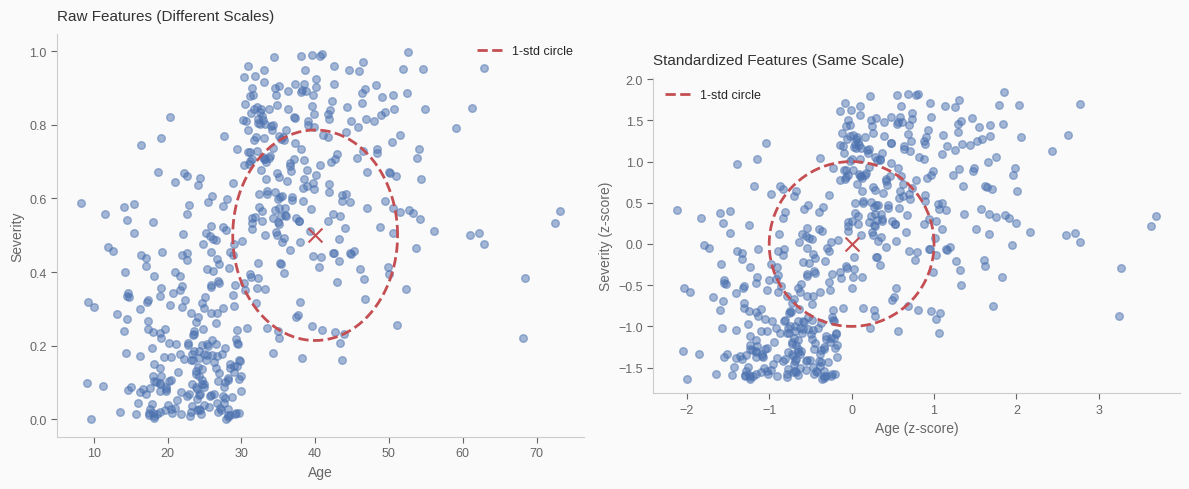

After standardization, both features contribute equally to distance.


In [6]:
# Visualize the effect of standardization
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Subset for visualization
np.random.seed(42)
sample_idx = np.random.choice(len(med), 500, replace=False)
X_sample = X[sample_idx]

# Left: Raw features
ax = axes[0]
ax.scatter(X_sample[:, 0], X_sample[:, 1], alpha=0.5, s=30, c=COLORS['blue'])
set_tufte_title(ax, "Raw Features (Different Scales)")
set_tufte_labels(ax, "Age", "Severity")

# Draw a unit circle (stretched by scales)
center = np.array([40, 0.5])
theta = np.linspace(0, 2*np.pi, 100)
# Circle with radius proportional to std
circle_x = center[0] + stds[0] * np.cos(theta)
circle_y = center[1] + stds[1] * np.sin(theta)
ax.plot(circle_x, circle_y, color=COLORS['red'], linewidth=2, linestyle='--', label='1-std circle')
ax.scatter([center[0]], [center[1]], color=COLORS['red'], s=100, marker='x', zorder=5)
ax.legend(frameon=False)

# Right: Standardized features
ax = axes[1]
X_std = (X_sample - means) / stds
ax.scatter(X_std[:, 0], X_std[:, 1], alpha=0.5, s=30, c=COLORS['blue'])
set_tufte_title(ax, "Standardized Features (Same Scale)")
set_tufte_labels(ax, "Age (z-score)", "Severity (z-score)")

# Draw unit circle (now truly circular)
center_std = np.array([0, 0])
circle_x = center_std[0] + np.cos(theta)
circle_y = center_std[1] + np.sin(theta)
ax.plot(circle_x, circle_y, color=COLORS['red'], linewidth=2, linestyle='--', label='1-std circle')
ax.scatter([0], [0], color=COLORS['red'], s=100, marker='x', zorder=5)
ax.legend(frameon=False)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("After standardization, both features contribute equally to distance.")

In [7]:
# Compare matching quality with different distance metrics
from sklearn.neighbors import NearestNeighbors

# Split into treated and control
treated_mask = med['medication'] == 1
X_treated = X[treated_mask]
X_control = X[~treated_mask]
Y_treated = med.loc[treated_mask, 'recovery'].values
Y_control = med.loc[~treated_mask, 'recovery'].values

# Standardize control group (for standardized matching)
scaler = StandardScaler()
X_control_std = scaler.fit_transform(X_control)
X_treated_std = scaler.transform(X_treated)

print(f"Treated: {len(X_treated)} patients")
print(f"Control: {len(X_control)} patients")

Treated: 6924 patients
Control: 13076 patients


In [8]:
def matching_ate(X_treated, X_control, Y_treated, Y_control, metric='euclidean'):
    """
    Estimate ATT using 1-nearest neighbor matching.
    """
    # Fit nearest neighbor on control group
    nn = NearestNeighbors(n_neighbors=1, metric=metric)
    nn.fit(X_control)
    
    # Find nearest control for each treated
    distances, indices = nn.kneighbors(X_treated)
    
    # Get matched control outcomes
    matched_control_outcomes = Y_control[indices.flatten()]
    
    # ATT = mean of (treated outcome - matched control outcome)
    individual_effects = Y_treated - matched_control_outcomes
    att = individual_effects.mean()
    se = individual_effects.std() / np.sqrt(len(individual_effects))
    
    return {
        'ATT': att,
        'SE': se,
        'mean_distance': distances.mean(),
        'max_distance': distances.max()
    }

# Compare metrics
print("MATCHING ESTIMATES BY DISTANCE METRIC:")
print("=" * 60)

# Naive (no matching)
naive_att = Y_treated.mean() - Y_control.mean()
print(f"\nNaive (no matching): ATT = {naive_att:.2f}")

# Euclidean on raw features
result_euc = matching_ate(X_treated, X_control, Y_treated, Y_control, 'euclidean')
print(f"\nEuclidean (raw features):")
print(f"  ATT = {result_euc['ATT']:.2f} (SE = {result_euc['SE']:.2f})")
print(f"  Mean match distance: {result_euc['mean_distance']:.3f}")

# Euclidean on standardized features
result_std = matching_ate(X_treated_std, X_control_std, Y_treated, Y_control, 'euclidean')
print(f"\nEuclidean (standardized):")
print(f"  ATT = {result_std['ATT']:.2f} (SE = {result_std['SE']:.2f})")
print(f"  Mean match distance: {result_std['mean_distance']:.3f}")

MATCHING ESTIMATES BY DISTANCE METRIC:

Naive (no matching): ATT = 16.90

Euclidean (raw features):
  ATT = -1.21 (SE = 0.08)
  Mean match distance: 0.118

Euclidean (standardized):
  ATT = -2.23 (SE = 0.08)
  Mean match distance: 0.242


In [9]:
# Mahalanobis matching
# Use scipy for Mahalanobis with precomputed covariance
from scipy.spatial.distance import cdist

# Compute Mahalanobis distances from all treated to all control
cov_matrix_full = np.cov(X.T)
cov_inv_full = np.linalg.inv(cov_matrix_full)

# For each treated, find nearest control by Mahalanobis
distances_mah = cdist(X_treated, X_control, metric='mahalanobis', VI=cov_inv_full)
nearest_indices = distances_mah.argmin(axis=1)
nearest_distances = distances_mah.min(axis=1)

# Get matched outcomes
matched_outcomes_mah = Y_control[nearest_indices]
effects_mah = Y_treated - matched_outcomes_mah
att_mah = effects_mah.mean()
se_mah = effects_mah.std() / np.sqrt(len(effects_mah))

print(f"\nMahalanobis:")
print(f"  ATT = {att_mah:.2f} (SE = {se_mah:.2f})")
print(f"  Mean match distance: {nearest_distances.mean():.3f}")

# Summary table
print(f"\n" + "=" * 60)
print("SUMMARY:")
print(f"{'Method':<25} {'ATT':<10} {'SE':<10} {'95% CI'}")
print("-" * 60)
print(f"{'Naive':<25} {naive_att:<10.2f} {'-':<10} -")
print(f"{'Euclidean (raw)':<25} {result_euc['ATT']:<10.2f} {result_euc['SE']:<10.2f} [{result_euc['ATT']-1.96*result_euc['SE']:.2f}, {result_euc['ATT']+1.96*result_euc['SE']:.2f}]")
print(f"{'Euclidean (standardized)':<25} {result_std['ATT']:<10.2f} {result_std['SE']:<10.2f} [{result_std['ATT']-1.96*result_std['SE']:.2f}, {result_std['ATT']+1.96*result_std['SE']:.2f}]")
print(f"{'Mahalanobis':<25} {att_mah:<10.2f} {se_mah:<10.2f} [{att_mah-1.96*se_mah:.2f}, {att_mah+1.96*se_mah:.2f}]")


Mahalanobis:
  ATT = -1.79 (SE = 0.08)
  Mean match distance: 0.190

SUMMARY:
Method                    ATT        SE         95% CI
------------------------------------------------------------
Naive                     16.90      -          -
Euclidean (raw)           -1.21      0.08       [-1.38, -1.05]
Euclidean (standardized)  -2.23      0.08       [-2.38, -2.07]
Mahalanobis               -1.79      0.08       [-1.95, -1.63]


---

## Implementation

### Match Quality Visualization

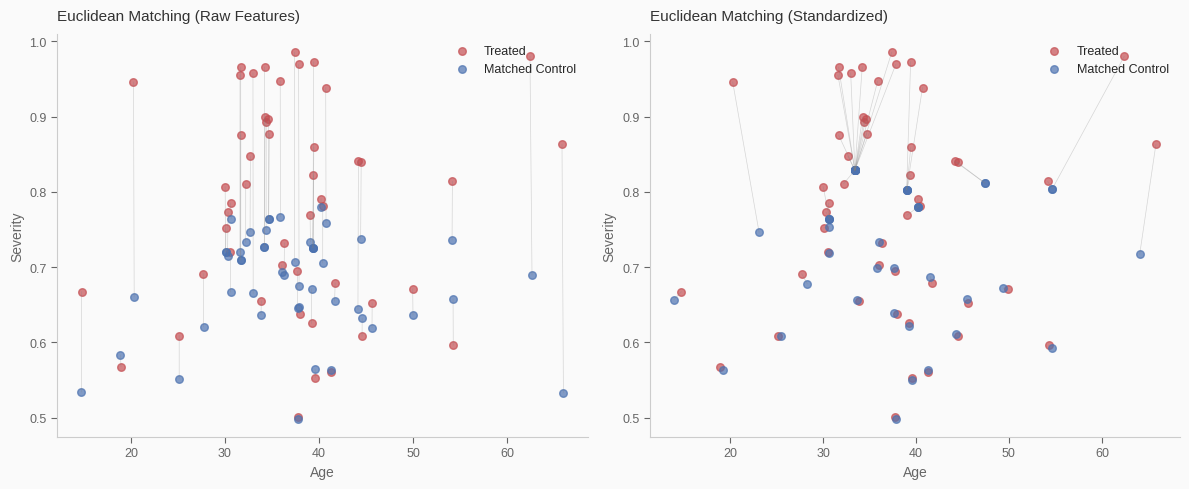

Standardized matching produces more balanced matches across both features.


In [10]:
# Visualize match quality for different metrics
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Get matches for visualization (subset)
np.random.seed(42)
viz_idx = np.random.choice(len(X_treated), 50, replace=False)

# Euclidean matches (raw)
nn_euc = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn_euc.fit(X_control)
_, euc_matches = nn_euc.kneighbors(X_treated[viz_idx])

ax = axes[0]
for i, (t_idx, c_idx) in enumerate(zip(viz_idx, euc_matches.flatten())):
    ax.plot([X_treated[t_idx, 0], X_control[c_idx, 0]], 
            [X_treated[t_idx, 1], X_control[c_idx, 1]], 
            color='gray', alpha=0.3, linewidth=0.5)
ax.scatter(X_treated[viz_idx, 0], X_treated[viz_idx, 1], 
           c=COLORS['red'], s=30, label='Treated', alpha=0.7)
ax.scatter(X_control[euc_matches.flatten(), 0], X_control[euc_matches.flatten(), 1], 
           c=COLORS['blue'], s=30, label='Matched Control', alpha=0.7)
set_tufte_title(ax, "Euclidean Matching (Raw Features)")
set_tufte_labels(ax, "Age", "Severity")
ax.legend(frameon=False, loc='upper right')

# Standardized Euclidean matches
nn_std = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn_std.fit(X_control_std)
_, std_matches = nn_std.kneighbors(X_treated_std[viz_idx])

ax = axes[1]
for i, (t_idx, c_idx) in enumerate(zip(viz_idx, std_matches.flatten())):
    ax.plot([X_treated[t_idx, 0], X_control[c_idx, 0]], 
            [X_treated[t_idx, 1], X_control[c_idx, 1]], 
            color='gray', alpha=0.3, linewidth=0.5)
ax.scatter(X_treated[viz_idx, 0], X_treated[viz_idx, 1], 
           c=COLORS['red'], s=30, label='Treated', alpha=0.7)
ax.scatter(X_control[std_matches.flatten(), 0], X_control[std_matches.flatten(), 1], 
           c=COLORS['blue'], s=30, label='Matched Control', alpha=0.7)
set_tufte_title(ax, "Euclidean Matching (Standardized)")
set_tufte_labels(ax, "Age", "Severity")
ax.legend(frameon=False, loc='upper right')

plt.tight_layout()
plt.show()

print("Standardized matching produces more balanced matches across both features.")

In [11]:
# Analyze match quality: covariate balance
def analyze_balance(X_treated, X_control_matched, feature_names):
    """Compute standardized mean differences (SMD) for balance check."""
    results = []
    for i, name in enumerate(feature_names):
        treat_mean = X_treated[:, i].mean()
        control_mean = X_control_matched[:, i].mean()
        pooled_std = np.sqrt((X_treated[:, i].var() + X_control_matched[:, i].var()) / 2)
        smd = (treat_mean - control_mean) / pooled_std
        results.append({
            'feature': name,
            'treated_mean': treat_mean,
            'control_mean': control_mean,
            'SMD': smd
        })
    return pd.DataFrame(results)

# Balance before matching
print("COVARIATE BALANCE ANALYSIS:")
print("=" * 60)
print("\nBefore matching:")
balance_before = analyze_balance(X_treated, X_control, features)
print(balance_before.to_string(index=False))

# Balance after Euclidean (raw)
print("\nAfter Euclidean (raw):")
nn_euc_full = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn_euc_full.fit(X_control)
_, euc_all_matches = nn_euc_full.kneighbors(X_treated)
balance_euc = analyze_balance(X_treated, X_control[euc_all_matches.flatten()], features)
print(balance_euc.to_string(index=False))

# Balance after standardized
print("\nAfter standardized Euclidean:")
nn_std_full = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn_std_full.fit(X_control_std)
_, std_all_matches = nn_std_full.kneighbors(X_treated_std)
balance_std = analyze_balance(X_treated, X_control[std_all_matches.flatten()], features)
print(balance_std.to_string(index=False))

print("\n" + "=" * 60)
print("SMD < 0.1 is generally considered good balance.")

COVARIATE BALANCE ANALYSIS:

Before matching:
 feature  treated_mean  control_mean    SMD
     age       38.8567       28.2348 1.0775
severity        0.7842        0.3033 2.9963

After Euclidean (raw):
 feature  treated_mean  control_mean     SMD
     age       38.8567       38.8568 -0.0000
severity        0.7842        0.6872  1.0252

After standardized Euclidean:
 feature  treated_mean  control_mean    SMD
     age       38.8567       38.7754 0.0087
severity        0.7842        0.7466 0.3774

SMD < 0.1 is generally considered good balance.


---

## Interview Appendix

### Practice Questions

**Q1: Why is feature scaling important for matching?**

<details>
<summary>Solution</summary>

Feature scaling is critical because:

**The Problem**: Different features have different scales (age in years, income in dollars, probability in 0-1). Without scaling, features with larger numeric ranges dominate distance calculations.

**Example**: Age difference of 5 years vs income difference of $50,000
- Raw Euclidean: Income dominates (50,000 >> 5)
- Standardized: Both contribute proportionally to their variability

**Solutions**:
1. **Standardization** (z-score): $\tilde{x} = (x - \bar{x}) / s$
   - Centers at 0, scales to unit variance
   - Most common approach

2. **Min-max scaling**: $\tilde{x} = (x - x_{min}) / (x_{max} - x_{min})$
   - Scales to [0, 1] range
   - Sensitive to outliers

3. **Mahalanobis distance**: Accounts for scale AND correlation
   - Uses covariance matrix
   - Most sophisticated

**Practical rule**: Always standardize before matching unless you have a principled reason not to.

</details>

**Q2: What is the Mahalanobis distance and when would you use it?**

<details>
<summary>Solution</summary>

**Definition**: Mahalanobis distance accounts for feature correlations:

$$d_{Mah}(x_i, x_j) = \sqrt{(x_i - x_j)' \Sigma^{-1} (x_i - x_j)}$$

**Intuition**: It measures distance in units of standard deviations along the principal axes of the data.

**When to use Mahalanobis**:
1. **Correlated features**: When features are strongly correlated, standardized Euclidean over-counts the "same" information. Mahalanobis adjusts for this.

2. **Example**: Education and income are correlated. A person with high education and high income isn't "twice as different" - they're different on one underlying dimension.

**When NOT to use**:
1. **Small samples**: Covariance matrix estimation is unstable
2. **High dimensions**: Covariance matrix may be singular
3. **Binary features**: Correlation structure may not be meaningful

**Practical note**: With propensity scores (Chapter 11), you match on a single scalar, avoiding the distance metric choice entirely.

</details>

**Q3: How do you assess matching quality?**

<details>
<summary>Solution</summary>

**Key metric: Standardized Mean Difference (SMD)**

$$SMD = \frac{\bar{X}_{treated} - \bar{X}_{control}}{\sqrt{(s^2_{treated} + s^2_{control})/2}}$$

**Interpretation**:
- SMD = 0: Perfect balance
- |SMD| < 0.1: Good balance (common threshold)
- |SMD| < 0.25: Acceptable balance
- |SMD| > 0.25: Poor balance, reconsider matching

**Other diagnostics**:
1. **Visual inspection**: Plot covariate distributions before/after matching
2. **Variance ratios**: Compare treated vs matched control variances (should be close to 1)
3. **Love plots**: Show SMD for all covariates before and after matching

**What to do if balance is poor**:
- Try different distance metrics
- Add more covariates
- Use caliper matching (maximum allowed distance)
- Consider propensity score methods

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 10.

[^2]: Rubin, D. B. (1980). Bias reduction using Mahalanobis-metric matching. *Biometrics*, 36(2), 293-298.

[^3]: Stuart, E. A. (2010). Matching methods for causal inference: A review and a look forward. *Statistical Science*, 25(1), 1-21.

[^4]: Cross-reference: Propensity score as dimension reduction in `11_propensity_score/01_balancing_score.ipynb`